In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# We need to create a line for 3.7 and a sine wave for 3.8
# x is our input variable or feature
# t is our target variable or output

def generate_linear_data(n, noise=0.2):
    x = np.random.uniform(-1, 1, n) # generates n random x values from -1 to 1
    t = -0.3 + 0.5*x + np.random.normal(0, noise, n) # generates t values from a straight line and we add gaussian noise (mean 0, stddev 0.2)
    return x, t

def generate_sine_data(n, noise=0.2):
    x = np.random.uniform(-1, 1, n) # same as before
    t = np.sin(2*np.pi*x) + np.random.normal(0, noise, n) # generates t values from a sine wave t = sin(2*pi*x)
    return x, t

In [3]:
def gaussian_basis(x, centers, width):
    return np.exp(-(x[:, None] - centers)**2 / (2*width**2))
    # Creates 9 gaussian exponential functions (bell curves) for 3.8 each centered at a different location
    # Each Gaussian "activates" (outputs high values) when x is near its center
    # When x is far from a center, that Gaussian outputs ~0
    # By weighting 9 bumps differently, we can approximate complex curves like sin(x)
    # This is more flexible than straight lines but still linear in w


In [4]:
def compute_gaussian_posterior(Phi, t, alpha, beta):
    S_N_inv = alpha*np.eye(Phi.shape[1]) + beta*Phi.T @ Phi
    S_N = np.linalg.inv(S_N_inv)
    m_N = beta * S_N @ Phi.T @ t
    return m_N, S_N
    # equations 3.53 and 3.54
    # S_N_inv is precision matrix (inverse of covariance) -> how confident we are about the weights
    # alpha*np.eye(Phi.shape[1]) -> prior precision where alpha is 2.0 (from book) and eye is just 9x9 identity matrix
    # a larger alpha means stronger belief that the weights are small (regularization term)
    # beta*Phi.T @ Phi is the precision of the data and Phi.T @ Phi measures the overlap between the basis functions 
    # if there is more data or lower noise beta term dominates otherwise less data/lower noise then alpha term dominates 

    # S_N is covariance matrix (inverse of precision matrix) where diagonal elements S_N[j,j] = variance of weight j and off-diagonal S_N[i,j] = how correlated weights i and j are
    # m_N is the posterior mean our guess for the weights 

In [5]:
def predict(Phi, m_N, S_N, beta):
    # equations 3.58 and 3.59
    mean = Phi @ m_N # mean is just the predictive mean -> our best guess for t at new locations of x
    variance = 1/beta + np.sum(Phi @ S_N * Phi, axis=1) # variance, basically how uncertain we are about these predictions
    # we have data noise which is the 1/beta term and the model uncertainty 
    return mean, np.sqrt(variance)

In [6]:
# 3.7 - sequential learning for y = w0 + w1*x
def figure_3_7():
    alpha, beta = 2.0, 25.0 # directly grabbed from the book 
    x_data, t_data = generate_linear_data(20) # make the 20 data points 
    
    fig, axes = plt.subplots(4, 3, figsize=(12, 12)) 
  
    w0, w1 = np.linspace(-1, 1, 100), np.linspace(-1, 1, 100)
    W0, W1 = np.meshgrid(w0, w1)
    w_grid = np.stack([W0.ravel(), W1.ravel()], axis=1)  # each row is now a one pair of (w0, w1)
    
    for row, n in enumerate([0, 1, 2, 20]): # plot 0, 1, 2, 20 points 
        if n == 0:
            m_N, S_N = np.zeros(2), (1/alpha)*np.eye(2) # gaussian prior ~ N(0, 1/alpha)
        else:
            Phi = np.column_stack([np.ones(n), x_data[:n]]) # make the matrix which each row is [1,x] the 1 is for intercept w0
            m_N, S_N = compute_gaussian_posterior(Phi, t_data[:n], alpha, beta)
            
            # for the likelihood graphing
            y = W0 + W1*x_data[n-1] # for the likelihood
            lik = np.exp(-0.5*beta*(t_data[n-1] - y)**2) # gaussian likelihood p(t|x,w,beta)
            axes[row,0].contourf(W0, W1, lik, 20)
            axes[row,0].plot(-0.3, 0.5, 'w+', ms=10)
            axes[row,0].set_xlabel(r"$w_0$")
            axes[row,0].set_ylabel(r"$w_1$")
        
        axes[row,0].set_title(f'Likelihood (N={n})')
        
        # for the posterior graphing 
        diff = w_grid - m_N
        post = np.exp(-0.5*np.sum(diff @ np.linalg.inv(S_N) * diff, axis=1)) # evaluating gaussian pdf
        axes[row,1].contourf(W0, W1, post.reshape(W0.shape), 20)
        axes[row,1].plot(-0.3, 0.5, 'w+', ms=10) # true parameters
        axes[row,1].set_title(f'Posterior (N={n})')
        axes[row,1].set_xlabel(r"$w_0$")
        axes[row,1].set_ylabel(r"$w_1$")
        
        # for the data samples graphing 
        x_plot = np.linspace(-1, 1, 100)
        for _ in range(6): 
            w = np.random.multivariate_normal(m_N, S_N) # we sample the weights from the posterior 
            axes[row,2].plot(x_plot, w[0] + w[1]*x_plot, 'r-', alpha=0.5, lw=1) # plot 6 samples line with these weights
        
        axes[row,2].plot(x_plot, -0.3 + 0.5*x_plot, 'g-', lw=2) # this is the true function 
        if n > 0:
            axes[row,2].plot(x_data[:n], t_data[:n], 'bo') # sampled data as circles 
        axes[row,2].set_ylim(-1, 1)
        axes[row,2].set_title(f'Data space (N={n})')
        axes[row,2].set_xlabel("x")
        axes[row,2].set_ylabel("t")
    
    plt.tight_layout()
    plt.show()

In [7]:
def figure_3_8():
    alpha, beta = 2.0, 25.0
    centers = np.linspace(-1, 1, 9)  # 9 gaussian basis functions
    width = 0.2 # how spread out each gaussian is

    x_data, t_data = generate_sine_data(25) # get 25 points from the t = sin(...) + noise

    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    axes = axes.ravel()

    for idx, n in enumerate([1, 2, 4, 25]):

        Phi_train = gaussian_basis(x_data[:n], centers, width) # nx9 matrix - each entry is x_n evaluated at each gaussian basis
        m_N, S_N = compute_gaussian_posterior(Phi_train, t_data[:n], alpha, beta) # m_N is the expected weights and S_N is the uncertainty 

        x_plot = np.linspace(-1, 1, 200) # here we plot the 200 evenly spaced x values 
        Phi_test = gaussian_basis(x_plot, centers, width) # makes the 200 new x values into gaussian features(200, 9)
        mean, std = predict(Phi_test, m_N, S_N, beta) # make the predictions 

        # Plot
        axes[idx].plot(x_plot, np.sin(2*np.pi*x_plot), 'g-', lw=2, label='True')
        axes[idx].plot(x_plot, mean, 'r-', lw=2, label='Mean')
        axes[idx].fill_between(x_plot, mean-std, mean+std, color='r', alpha=0.2, label='±1σ')
        axes[idx].plot(x_data[:n], t_data[:n], 'bo', ms=8)
        axes[idx].set_xlim(-1, 1)
        axes[idx].set_ylim(-1.5, 1.5)
        axes[idx].set_title(f'N = {n}')
        axes[idx].set_xlabel('x')
        axes[idx].set_ylabel('t')
        if idx == 0:
            axes[idx].legend()

    plt.tight_layout()
    plt.show()

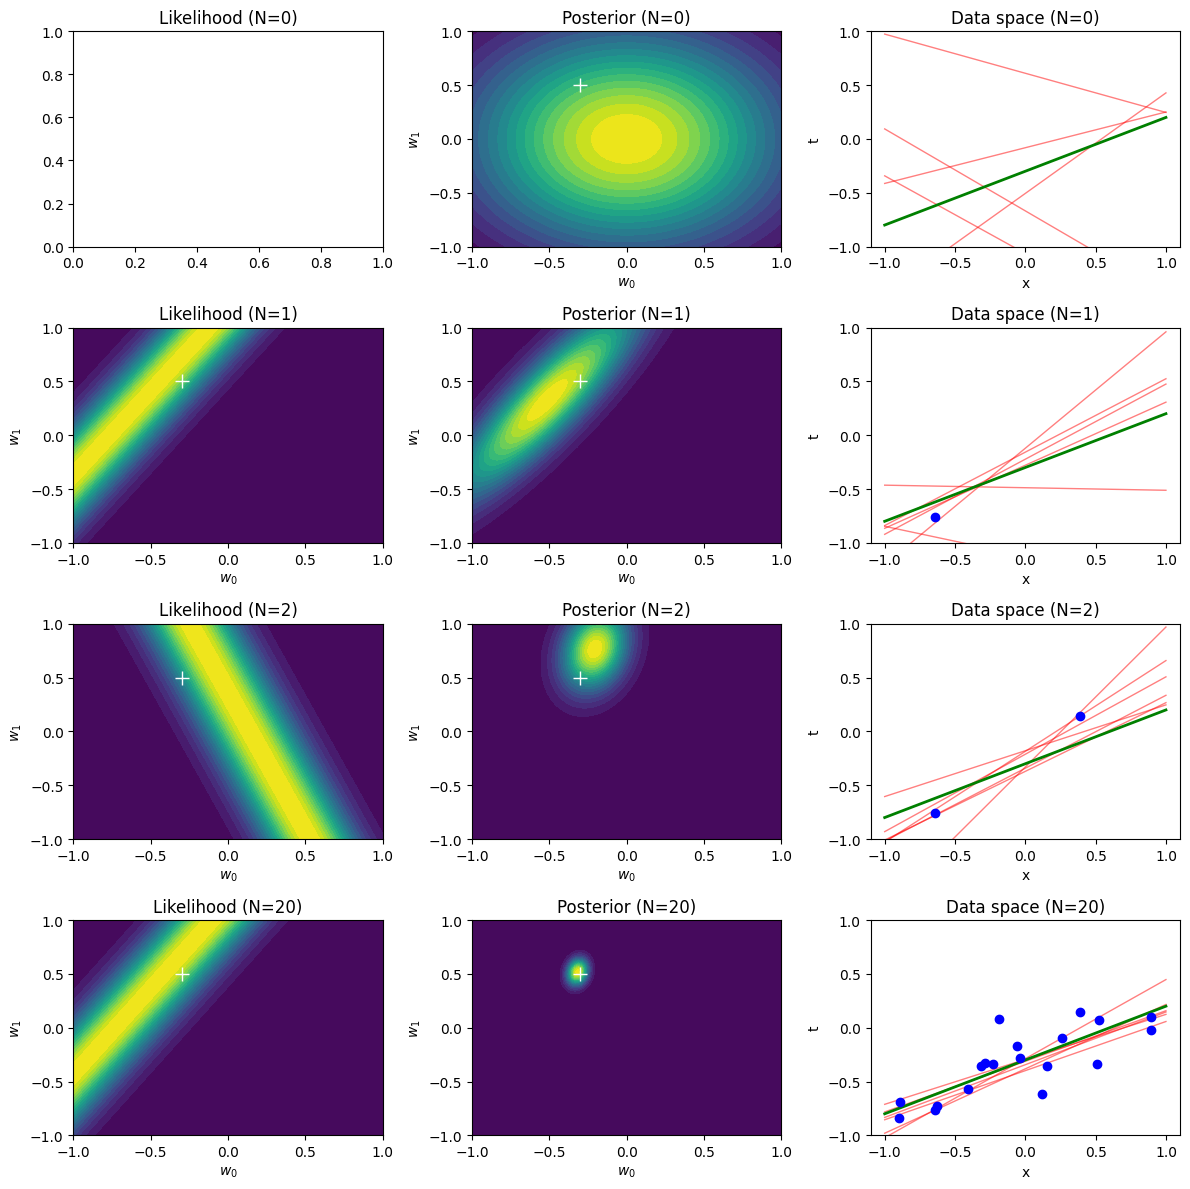

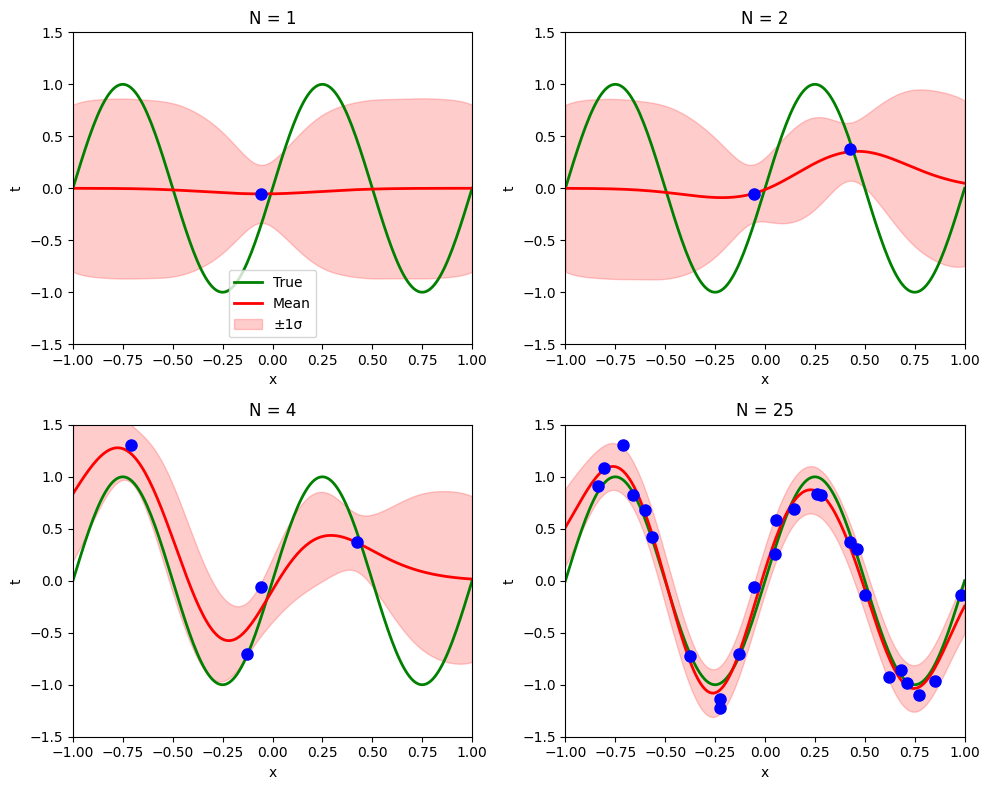

In [8]:
figure_3_7()
figure_3_8()